In [1]:
Seed = 7

In [209]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model


In [117]:
#inporting all the data
remote_sensing_reflectance = pd.read_csv("all_habs_rrs_only.csv").fillna(0)
shatonela_diatom = pd.read_csv("all_concatinated_data.csv", low_memory=False)
karenia = pd.read_csv("all_karenia_data.csv", low_memory=False)  # import karenia data from the server here

In [118]:
# combining shatonela diatom and karenia data together
akashivo_data = pd.concat([shatonela_diatom, karenia], axis=0)
akashivo_data.to_csv("akashivo_data.csv", encoding='utf-8-sig')
akashivo_data.rename(columns ={'緯度':'lat', '経度':'lon', '採取日':'date', 'シャットネラ属':'shatonela', '珪藻類合計':'diatom', 'カレニア　ミキモトイ':'karenia'} , inplace = True)
akashivo_data.drop(['Unnamed: 4', '赤潮細胞数の単位', '採水層', '地点名'], inplace=True, axis=1)

In [119]:
# connect the two dataframes with lat logn and date
merged_data = pd.merge(akashivo_data, remote_sensing_reflectance, on=["lat", "lon", "date"], how = 'left').fillna(0)
merged_data.drop(['Unnamed: 0.1', 'Unnamed: 0', 'identifier', 'file_status', 'download_url', 'preview_url', 'resolution'], inplace=True, axis=1)
print(merged_data['karenia'])

0             0.0
1             0.0
2             0.0
3             0.0
4             0.0
           ...   
253649     2040.0
253650    80500.0
253651    80500.0
253652    26750.0
253653    26750.0
Name: karenia, Length: 253654, dtype: float64


In [120]:
# filder all the duplicates
columns_to_check = ['shatonela', 'diatom', 'karenia', 'Rrs_380', 'Rrs_412', 'Rrs_443', 'Rrs_490', 'Rrs_530', 'Rrs_565', 'Rrs_670']
filtered_df = merged_data[~merged_data.duplicated(subset=columns_to_check, keep='first')]
filtered_df = filtered_df[~(filtered_df[['Rrs_380', 'Rrs_412', 'Rrs_443', 'Rrs_490', 'Rrs_530', 'Rrs_565', 'Rrs_670']] <= 0).any(axis=1)]
filtered_df.to_csv("data.csv", encoding="utf-8-sig")

In [121]:
# modifing the data to the correct form
output_colums = filtered_df[['shatonela', 'diatom', 'karenia']]
input_colums = filtered_df[['Rrs_380', 'Rrs_412', 'Rrs_443', 'Rrs_490', 'Rrs_530', 'Rrs_565', 'Rrs_670']]
print(len(input_colums))

7355


In [122]:
# putting Rrs thrue a log`
# scaler = MinMaxScaler()
# x = scaler.fit_transform(input_colums)
x = np.log(input_colums)

x.shape

(7355, 7)

In [123]:
# converts all the values in to 1es and 0es
y = (output_colums > 0).any(axis=1)
y = np.array(y)

In [183]:
np.random.seed(Seed)
tf.random.set_seed(Seed)
Seed += 1

In [184]:
# randomaizing test and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=Seed)

In [185]:
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=Seed)

In [195]:
def build_model():
    model = models.Sequential()

    model.add(layers.Reshape((1, 7), input_shape=(7,)))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer='adam',
                  
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [202]:
model = build_model()

early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor = 'val_accuracy')
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, monitor='val_loss')

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=100,
                    batch_size=500,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])



Epoch 1/100
9/9 [==============================] - 1s 33ms/step - loss: 0.6678 - accuracy: 0.6389 - val_loss: 0.6405 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 6ms/step - loss: 0.6493 - accuracy: 0.6610 - val_loss: 0.6425 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 0.6455 - accuracy: 0.6644 - val_loss: 0.6382 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6417 - accuracy: 0.6649 - val_loss: 0.6368 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 0.6384 - accuracy: 0.6651 - val_loss: 0.6319 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6343 - accuracy: 0.6651 - val_loss: 0.6273 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6315 - accurac

In [203]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

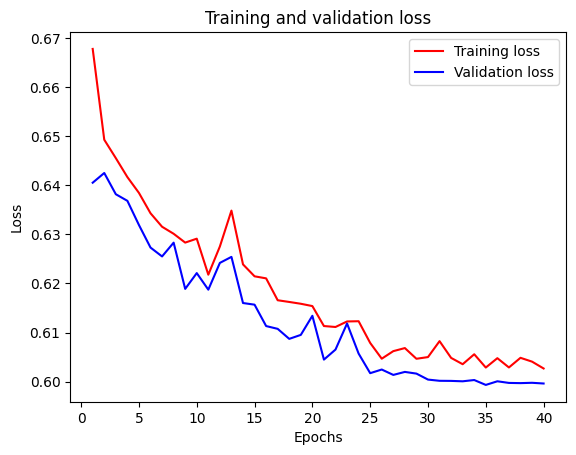

In [204]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

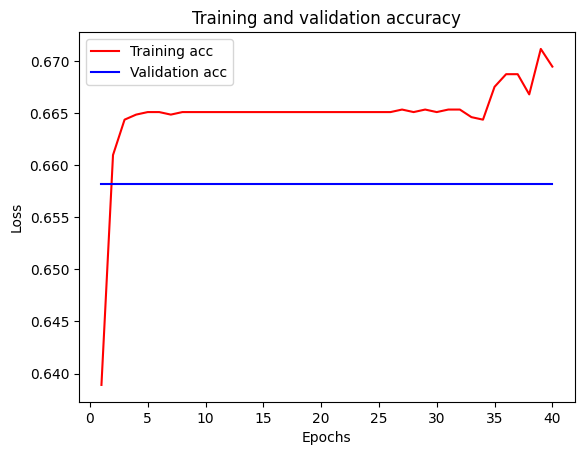

In [205]:
plt.clf() 
acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [208]:
best_model = load_model("best_model.keras")
loss, accuracy = best_model.evaluate(x_val, y_val)

print(f"Accuracy: {accuracy * 100:.2f}%")

33/33 [==============================] - 0s 760us/step - loss: 0.5993 - accuracy: 0.6583
Accuracy: 65.83%


In [207]:
# model.save('my_model.h5')